# Plate Reader Growth Rate - Fig S7

Transformed sgRNAs against genes of interest into MG1655 + dCas9 (gAM-130). WT-like control is Rand42.
Grew overday in LB + 35 Kan, washed 2x into M9 + 35 Kan and diluted to OD 0.05. Grew overnight.
Washed into M9 + 35 Kan + 50 ng/mL ATc 2x and diluted to OD 0.005. Grew 5.5 hours.
Diluted to OD 0.005 into M9 + 35 Kan + 50 ng/mL ATc.
Into Victor plate reader 37C 40 cycles.

Written by Ryan Otto

Updated 9/23/20

## Import useful libraries

In [1]:
import pandas as pd # Data organization
import numpy as np # Data organization
import matplotlib.pyplot as plt # Plotting function
from scipy import stats # For linear regression and sem calculations
import datetime # For timepoint calculations
# Render figures in notebook
%matplotlib inline

## Establish paths and variables unique to this analysis

In [2]:
# Establish file paths
input_path = 'inputs/' # General path for input files
growth_path = 'outputs/20200923_df_growth_Glu.csv' # Path to turbidostat growth rate data
figure_path = 'Figures/' # General path for saving figures

Reps = 3 # Number of replicate measurements per well per timepoint

Timepoints = 20 # How many measurements were taken -- can use this to truncate a death phase near the end

groups = ['none'] # Names of "groups" to separate cell lines between plots. If you want one plot, type 'none'
# For grouping to work, each cell line must begin with the name of the group it belongs to

file_list = ['20200730_plate_reader.txt'] # Files to be analyzed. 
# Can enter multiple, assuming they each begin with unique identifiers

# Assign wells to samples in dictionary. The keys wells_dict should be the file identifier for each file in
# file_list. This identifier is whatever appears before the first underscore (I'd recommend a date)
# Each of the values in wells_dict will be another dictionary, this time with keys being the guides
# analyzed in each of these files. 
# A WT-growth control should be present in each of these subdictionaries. These must also start with the unique file
# identifier to distinguish between the controls when passing multiple files.
wells_dict = {}
wells_dict['20200730'] = {'topA1-C':['D02', 'D03', 'D04'], 'topA3-C':['D05', 'D06', 'D07'], 
                          'ispA1-C':['D08', 'D09', 'D10'], 'ispA3-C':['E02', 'E03', 'E04'], 
                          'mukF1-C':['E05', 'E06', 'E07'], 'mukF3-C':['E08', 'E09', 'E10'], 
                          'ribB1-C':['F02', 'F03', 'F04'], 'ribB3-C':['F05', 'F06', 'F07'], 
                          'tadA1-C':['F08', 'F09', 'F10'], 'tadA3-C':['G02', 'G03', 'G04'], 
                          '20200730_Rand42':['B11', 'C11', 'D11']}

WT_control_name = 'Rand42' # Name used for WT-like growth controls

# Dictionary converting turbidostat guide names to shorthand
translate_dict = {'folA_1_56_C':'folA1-C', 'thyA_1_60_C':'thyA1-C', 'topA_1_86_C':'topA1-C', 
                  'topA_3_207_C':'topA3-C', 'ispA_1_10_C':'ispA1-C', 'ispA_3_205_C':'ispA3-C', 
                  'mukF_1_14_C':'mukF1-C', 'mukF_3_206_C':'mukF3-C', 'ribB_1_20_C':'ribB1-C', 
                  'ribB_3_201_C':'ribB3-C', 'tadA_1_21_C':'tadA1-C', 'tadA_3_233_C':'tadA3-C', 
                  'gyrB_2_101_C':'gyrB'}

# Date stamp on all outputs
date = '20200923'

## Import data

In [3]:
# Import plate reader raw data
raw_data = {}
data_dict = {}
data_dict_log = {}
for file_name in file_list:
    file_identifier = file_name.split('_')[0]
    raw_data[file_identifier] = []
    with open(input_path + file_name, 'r') as FI:
        for line in FI:
            sp = line.split('\t')
            if sp[0] == '1':
                raw_data[file_identifier].append(line)

    for line in raw_data[file_identifier]:
        sp = line.split('\t')
        TP = sp[1] # Timepoint recorded in file
        Loc = sp[2] # Location in 96 well plate
        growth_rates = []
        if int(TP) <= Timepoints:
            for guide in wells_dict[file_identifier]:
                if Loc in wells_dict[file_identifier][guide]:
                    if guide not in data_dict.keys():
                        data_dict[guide] = {}
                        data_dict_log[guide] = {}
                        for rep in range(Reps):
                            data_dict[guide][rep] = {}
                            data_dict_log[guide][rep] = {}
                    for rep in range(Reps):
                        growth_rates.append(float(sp[5 + (2*rep)][0:5]))
                    data_dict[guide][wells_dict[file_identifier][guide].index(Loc)][int(TP)-1] = growth_rates
                    data_dict_log[guide][wells_dict[file_identifier][guide].index(Loc)][int(TP)-1] = \
                                                                                            np.log2(growth_rates)


# Turbidostat-calculated growth rate data
turbidostat_growth = pd.read_csv(growth_path, parse_dates=True, index_col=0)

guide_growth = {}
guide_sem = {}
for guide in translate_dict.keys():
    guide_growth[translate_dict[guide]] = turbidostat_growth['mean-cor'].loc[guide]
    guide_sem[translate_dict[guide]] = turbidostat_growth['sem-cor'].loc[guide]

In [4]:
# Normalizing data by subtracting background from three timepoints in each well
data_dict_sub = {}
data_dict_log_sub = {}
for guide in data_dict.keys():
    data_dict_sub[guide] = {}
    data_dict_log_sub[guide] = {}
    for rep in range(Reps):
        data_dict_sub[guide][rep] = {}
        data_dict_log_sub[guide][rep] = {}
    
        for TP in data_dict[guide][rep].keys():
            well_background = [np.mean([x, y, z]) for x, y, z in 
                               zip(data_dict[guide][rep][0], data_dict[guide][rep][1], data_dict[guide][rep][2])]
            
            data_dict_sub[guide][rep][TP] = [x - y for x, y in zip(data_dict[guide][rep][TP], well_background)]
            
            data_dict_log_sub[guide][rep][TP] = [np.log2(x-y) for x, y in 
                                                 zip(data_dict[guide][rep][TP], well_background)]

/Users/rotto/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2
/Users/rotto/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log2


In [5]:
# Calculating the time gap between data points
FMT = '%H:%M:%S.%f' # Datetime formatting
gap1 = []
gap2 = []
gap3 = []
for file_name in file_list:
    file_identifier = file_name.split('_')[0]
    rep1time = []
    rep2time = []
    rep3time = []
    for n, line in enumerate(raw_data[file_identifier]):
        sp = line.split('\t')
        if int(sp[0]) == 1:
            rep1time.append(datetime.datetime.strptime(sp[4], FMT))
            rep2time.append(datetime.datetime.strptime(sp[6], FMT))
            rep3time.append(datetime.datetime.strptime(sp[8], FMT))
    rep1min = np.zeros(len(rep1time))
    rep2min = np.zeros(len(rep2time))
    rep3min = np.zeros(len(rep3time))
    # Time of each measurement in minutes
    for i in range(len(rep1time)):
        rep1min[i] = rep1time[i].hour*60 + rep1time[i].minute + np.true_divide(rep1time[i].microsecond, 60000000)
    for i in range(len(rep2time)):
        rep2min[i] = rep2time[i].hour*60 + rep2time[i].minute + np.true_divide(rep2time[i].microsecond, 60000000)
    for i in range(len(rep3time)):
        rep3min[i] = rep3time[i].hour*60 + rep3time[i].minute + np.true_divide(rep3time[i].microsecond, 60000000)

    # Difference in time between measurements
    temp_gap1 = [x - y for x, y in zip(rep2min, rep1min)]
    temp_gap2 = [x - y for x, y in zip(rep3min, rep2min)]
    temp_gap3 = [x - y for x, y in zip(rep1min[96:], rep3min[:-96])] # Shift the frame for Reps 1 and 3

    gap1 = np.concatenate((gap1, temp_gap1))
    gap2 = np.concatenate((gap2, temp_gap2))
    gap3 = np.concatenate((gap3, temp_gap3))

# Fixes for shift in day on overnight runs
for i, value in enumerate(gap1):
    if value < 0:
        gap1[i] += 24*60 # Number of minutes in a day
for i, value in enumerate(gap2):
    if value < 0:
        gap2[i] += 24*60
for i, value in enumerate(gap3):
    if value < 0:
        gap3[i] += 24*60

avg_gap1 = np.mean(gap1)
avg_gap2 = np.mean(gap2)
avg_gap3 = np.mean(gap3)

print ('Gap1 = ' + str(avg_gap1) + ' minutes')
print ('Gap2 = ' + str(avg_gap2) + ' minutes')
print ('Gap3 = ' + str(avg_gap3) + ' minutes')

# Use average distance to create a representative timepoints array
TimeGap = 0 + avg_gap1 + avg_gap2 + avg_gap3
TStandard = range(Timepoints)
TRep1 = [x*TimeGap for x in TStandard]
TRep2 = [x+avg_gap1 for x in TRep1]
TRep3 = [x+avg_gap2 for x in TRep2]
TPs = sorted(TRep1 + TRep2 + TRep3)
TPs = np.true_divide(np.array(TPs), 60) # Puts in hours

Gap1 = 11.960127213541666 minutes
Gap2 = 11.958624348958331 minutes
Gap3 = 15.294330306267806 minutes


## Visualize growth in all wells

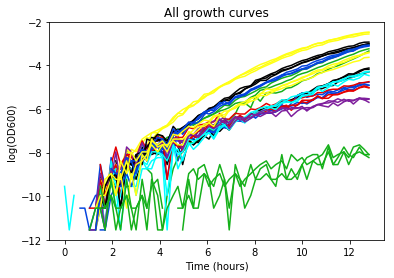

In [6]:
# Plot relevant growth curves
col = ['xkcd:black', 'xkcd:blue', 'xkcd:yellow', 'xkcd:green', 'xkcd:red', 'xkcd:cyan', 'xkcd:purple']
for i, guide in enumerate(data_dict_log_sub.keys()):
    for rep in range(Reps):
        plt.plot(TPs, np.hstack(data_dict_log_sub[guide][rep].values()), color = col[i%len(col)])
plt.xlabel('Time (hours)')
plt.ylabel('log(OD600)')
plt.title('All growth curves')
plt.show()

## Fit a linear exponential growth rate

/Users/rotto/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater_equal
/Users/rotto/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal


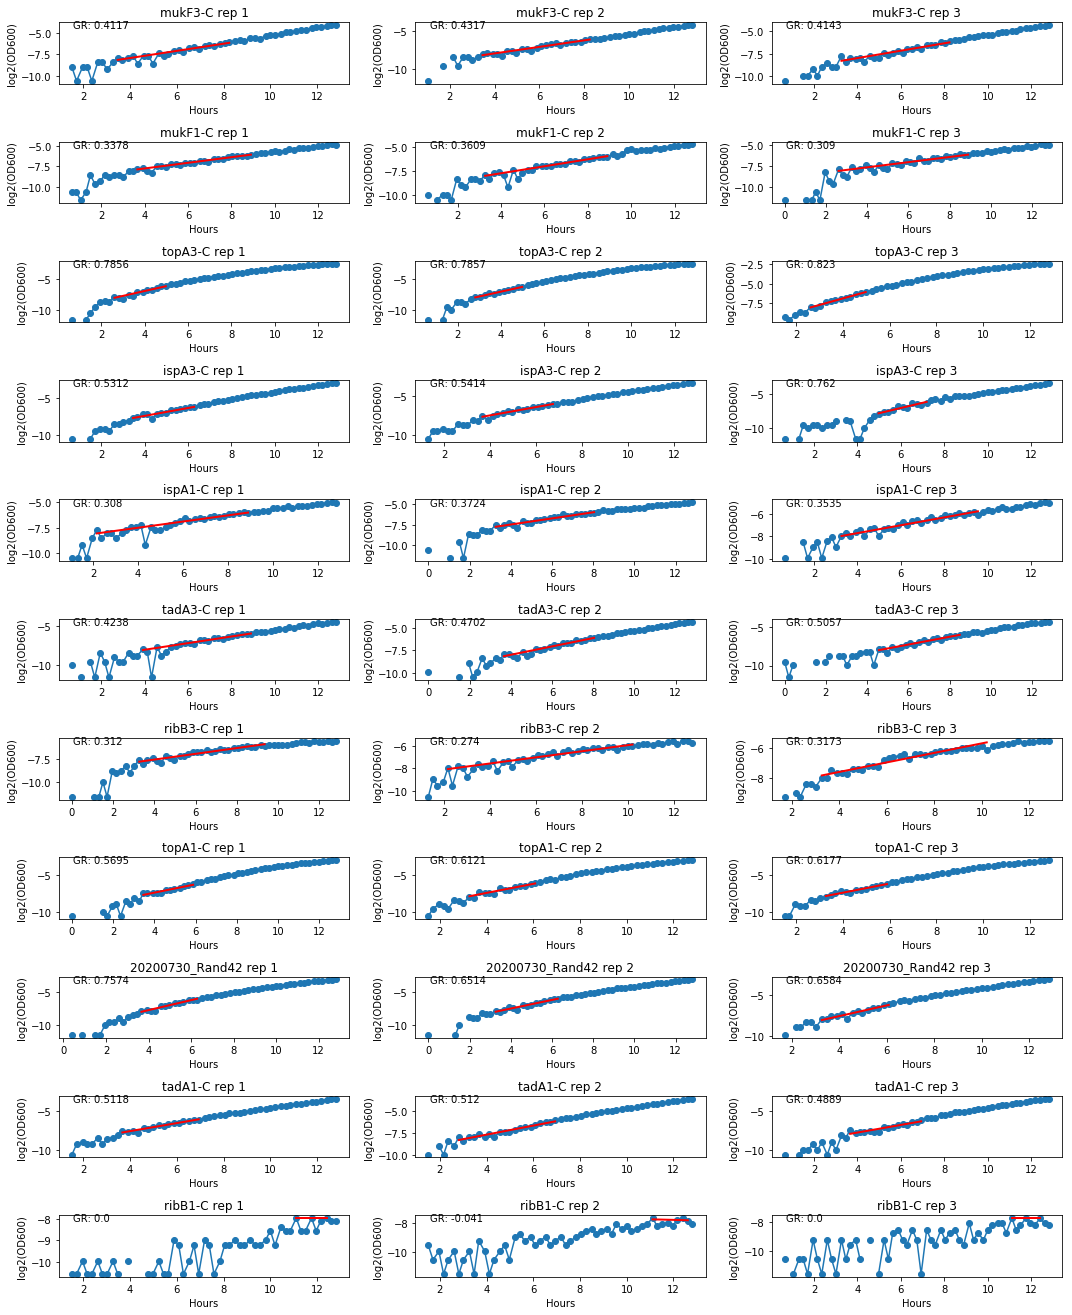

In [7]:
# Fit data according to linear range
gr_dict = {} # Growth rate dictionary
area_dict = {} # AUC dictionary
k = 1 # Subplot indexing

fig = plt.figure(figsize=(15, len(data_dict_log_sub.keys()*6)))
for guide in data_dict_log_sub.keys():
    gr_dict[guide] = np.zeros(Reps)
    area_dict[guide] = np.zeros(Reps)
    for rep in range(Reps):
        FW = np.hstack(data_dict_log_sub[guide][rep].values())
        FW_noBS = np.hstack(data_dict_log[guide][rep].values())
        x = []
        y = []
        xA = []
        yA = []
        RI = np.where(np.logical_and(FW>=-8, FW<=-6)) # Range index locations
        for index in np.hstack(RI):
            x.append(TPs[index])
            y.append(FW[index])
        if len(y) > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            Log_OD_pos = FW_noBS + abs(min(FW_noBS)) # Shifts data to be positive
            area = np.trapz(Log_OD_pos, TPs) # Integrates whole growth range
            gr_dict[guide][rep] = slope
            area_dict[guide][rep] = abs(area)
        else:
            slope, intercept, r_value, p_value, std_err = 0, 0, 0, 0, 0
            Log_OD_pos = FW_noBS + abs(min(FW_noBS)) # Shifts data to be positive
            area = np.trapz(Log_OD_pos, TPs) # Integrates whole growth range
            gr_dict[guide][rep] = slope
            area_dict[guide][rep] = abs(area)

        ax = fig.add_subplot(40, 3, k)
        plt.plot(TPs, FW, label=value, marker='o')
        plt.text(0.05, 0.9, 'GR: ' + str(np.round(gr_dict[guide][rep], 4)), transform=ax.transAxes)

        try:
            x = np.array(x)
            plt.plot(x, slope*x + intercept, '-r', linewidth=2)
        except:
            print(guide + ' can not fit line')
            print(str(x) + '   slope: ' + str(slope) + '   intercept: ' + str(intercept))
        plt.title(guide + ' rep ' + str(rep+1))
        plt.xlabel('Hours')
        plt.ylabel('log2(OD600)')
        k = k + 1
    plt.tight_layout()
plt.show()

In [8]:
# Average growth data and plot points
# Initialize dictionaries
mean_gr_dict = {}
sem_gr_dict = {}
mean_area_dict = {}
sem_area_dict = {}
gr_labels = []
for guide in gr_dict.keys():
    temp_gr = gr_dict[guide]
    temp_area = area_dict[guide]

    mean_gr = np.mean(np.array(temp_gr))
    sem_gr = stats.sem(temp_gr)
    mean_area = np.mean(np.array(temp_area))
    sem_area = stats.sem(temp_area)

    # Replace not at number nan with 0
    if str(mean_gr) == 'nan':
        mean_gr = np.mean(np.nan_to_num(np.array(temp_gr)))
    if str(sem_gr) == 'nan':
        sem_gr = stats.sem(np.nan_to_num(np.array(temp_gr)))
    if str(mean_area) == 'nan':
        mean_area = np.mean(np.nan_to_num(np.array(temp_area)))
    if str(sem_area) == 'nan':
        sem_area = stats.sem(np.nan_to_num(np.array(temp_area)))
    # Save calculated values into a dictionary
    mean_gr_dict[guide] = mean_gr
    sem_gr_dict[guide] = sem_gr
    mean_area_dict[guide] = mean_area
    sem_area_dict[guide] = sem_area

In [9]:
# Normalize to WT-like control growth rate
# Initialize dictionaries
norm_gr_dict = {}
norm_area_dict = {}
norm_gr_sem_dict = {}
norm_area_sem_dict = {}
for guide in mean_gr_dict.keys():
    for file_name in file_list:
        file_identifier = file_name.split('_')[0]
        if guide in wells_dict[file_identifier].keys():
            norm_gr_dict[guide] = mean_gr_dict[guide] - mean_gr_dict[file_identifier + '_' + WT_control_name]
            norm_area_dict[guide] = mean_area_dict[guide] - mean_area_dict[file_identifier + '_' + WT_control_name]
            norm_gr_sem_dict[guide] = \
                        (sem_gr_dict[guide]**2 + sem_gr_dict[file_identifier + '_' + WT_control_name]**2)**(0.5)
            norm_area_sem_dict[guide] = \
                        (sem_area_dict[guide]**2 + sem_area_dict[file_identifier + '_' + WT_control_name]**2)**(0.5)

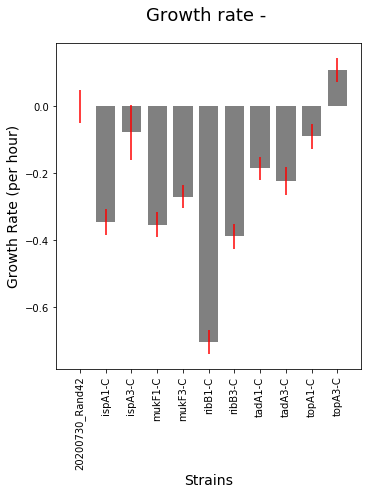

In [10]:
# Plot growth rates
for i, group in enumerate(groups):
    if group == 'none':
        group = ''
    plt.figure(figsize=(12, 6))
    growth_rate = []
    growth_sem = []
    label = []
    ind = 0
    width = 0.75
    for guide in sorted(norm_gr_dict.keys()):
        if guide.startswith(group):
            growth_rate.append(norm_gr_dict[guide])
            growth_sem.append((norm_gr_sem_dict[guide]))
            label.append(guide)
            ind += 1
    ind = np.arange(ind)
    plt.subplot(1, 2, i + 1)
    plt.bar(ind + width, growth_rate, width, color='grey', ecolor='r', yerr=growth_sem)
    plt.xticks(ind + width, label, rotation=90)
    plt.xlabel('Strains', fontsize = 14)
    plt.ylabel('Growth Rate (per hour)', fontsize=14)
    plt.title('Growth rate - ' + group, y=1.05, fontsize=18)
    plt.show()

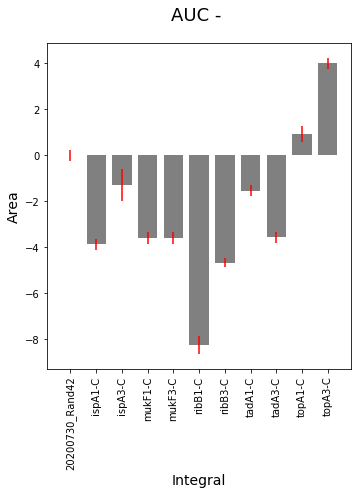

In [11]:
# Plot area under growth curve
for i, group in enumerate(groups):
    if group == 'none':
        group = ''
    plt.figure(figsize=(12, 6))
    label = []
    area_array = []
    area_sem = []
    ind = 0
    width = 0.75
    for guide in sorted(norm_gr_dict.keys()):
        if guide.startswith(group):
            area_array.append(norm_area_dict[guide])
            area_sem.append((norm_area_sem_dict[guide]))
            label.append(guide)
            ind += 1
    ind = np.arange(ind)
    plt.subplot(1, 2, i + 1)
    plt.bar(ind + width, area_array, width, color='grey', ecolor='r', yerr=area_sem)
    plt.xticks(ind + width, label, rotation=90)
    plt.xlabel('Integral', fontsize=14)
    plt.ylabel('Area', fontsize=14)
    plt.title('AUC - ' + group, y=1.05, fontsize=18)
    plt.show()

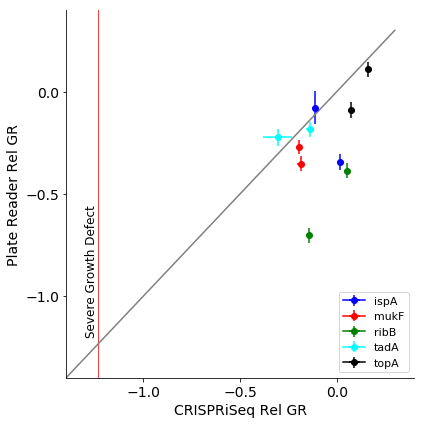

In [12]:
# Figure S7A
col = ['blue', 'blue', 'red', 'red', 'green', 'green', 'cyan', 'cyan', 'black', 'black'] # Colors for plotting
guide_names = norm_gr_dict.keys()
guide_names.sort()
guide_list = guide_names[1:] # Truncate the normalization control

plt.figure(figsize=(6, 6))
for i, guide in enumerate(guide_list):
    if '1' in guide: # Ensures that legend is correct
        plt.errorbar(guide_growth[guide], norm_gr_dict[guide], xerr=guide_sem[guide], 
                     yerr=norm_gr_sem_dict[guide], color=col[i], label=guide[0:4], marker='o')
    elif '3' in guide:
        plt.errorbar(guide_growth[guide], norm_gr_dict[guide], xerr=guide_sem[guide], 
                     yerr=norm_gr_sem_dict[guide], color=col[i], marker='o')
    plt.ylabel('Plate Reader Rel GR', fontsize=14)
    plt.xlabel('CRISPRiSeq Rel GR', fontsize=14)
    plt.xlim([-1.4, 0.4])
    plt.ylim([-1.4, 0.4])
plt.legend(fontsize=11)
plt.plot([guide_growth['gyrB'], guide_growth['gyrB']], [-1.5, 0.5], color='r', lw=0.75)
plt.text(-1.3, -0.6, 'Severe Growth Defect', rotation=90, fontsize=12)
plt.xticks([-1.0, -0.5, 0], fontsize=14)
plt.yticks([-1.0, -0.5, 0], fontsize=14)
plt.plot([-1.4, 0.3], [-1.4, 0.3], color='gray')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(figure_path + date + '_plate_reader_essentials_FigS7A.pdf', transparent=True)
plt.show()